In [47]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Gathering

In [48]:
def flatten_and_convert(data):
    """Flattens nested lists and converts elements to numeric values."""
    flat_list = []
    for item in data:
        if isinstance(item, (list, tuple, np.ndarray)):
            flat_list.extend(flatten_and_convert(item))
        else:
            flat_list.append(item)
    return flat_list


def remove_outliers(data):
    # Ensure the data is a flat numpy array of numeric values
    flat_data = flatten_and_convert(data)
    numeric_data = np.array([x for x in flat_data if isinstance(x, (int, float))])

    q1 = np.percentile(numeric_data, 25)
    q3 = np.percentile(numeric_data, 75)
    IQR = q3 - q1

    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    filtered = numeric_data[(numeric_data >= lower_bound) & (numeric_data <= upper_bound)]
    return filtered

In [49]:
def read_data(file_name):
    with open(file_name) as f:
        lns = f.readlines()
    data = np.array([float(i.split(',')[1].strip()) for i in lns[1:]])

    # Remove outliers from data
    data = remove_outliers(data)
    return data

In [50]:
def get_all_metrics(path, metric):
    data = {}
    # metrics = ["cpu", "memSet", "mem", "netIn", "netOut", "fsRead", "fsWrite",]
    # for m in metrics:
    d = read_data(os.path.join(path, metric))
        # data[m] = d
    return d

In [51]:
def sort_timestamps(timestamps):
    timestamps_as_datetime = [datetime.fromisoformat(ts.rstrip('Z')) for ts in timestamps]    
    sorted_datetimes = sorted(timestamps_as_datetime)
    sorted_timestamps = [dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z' for dt in sorted_datetimes]    
    return sorted_timestamps

In [52]:
def get_all_execs(path):
    execs = []
    for root, dirs, files in os.walk(path):
        for dir_name in dirs:
            # dir_path = os.path.join(root, dir_name)
            execs.append(dir_name)
    execs = sort_timestamps(execs)
    sub = list(map(lambda ts: path + "/" + ts, execs))

    data = {
        "cpu": [], 
        "memSet":[], 
        "mem":[],
        "netIn":[],
        "netOut":[], 
        "fsRead":[],
        "fsWrite":[]
    }
    metrics = ["cpu", "memSet", "mem", "netIn", "netOut", "fsRead", "fsWrite",]
    for m in metrics:
        for s in sub:
            x = get_all_metrics(s, m)
            data[m].append(x)
    return data

# STATS

In [185]:
def calculate_statistics(numbers):
    # Flatten the list of arrays into a single array
    # numbers = np.concatenate(numbers)
    mean = np.mean(numbers)
    median = np.median(numbers)
    std_deviation = np.std(numbers)
    
    return [mean, median, std_deviation]


def bytes_to_gigabytes(bytes_num):
    gigabytes = bytes_num / (1024 ** 3)  # Convert bytes to gigabytes
    return f"{gigabytes:.2f} GB"


def bytes_to_megabytes(bytes_num):
    gigabytes = bytes_num / (1024 ** 2)  # Convert bytes to gigabytes
    return f"{gigabytes:.2f} MB"

def bytes_to_kilobytes(bytes_num):
    gigabytes = bytes_num / (1024 ** 1)  # Convert bytes to gigabytes
    return f"{gigabytes:.2f} KB"


def get_inc_stats(data):
    stats = {
        "mean": [],
        "median": [],
        "std_d": []
    }
    for j in data:
        s = calculate_statistics(j)
        stats["mean"].append(s[0])
        stats["median"].append(s[1])
        stats["std_d"].append(s[2])
         
    return stats


def x(data):
    result = {
        "cpu": [], 
        "memSet":[], 
        "mem":[],
        "netIn":[],
        "netOut":[], 
        "fsRead":[],
        "fsWrite":[]
    }
    for m in ["cpu", "memSet", "mem", "netIn", "netOut", "fsRead", "fsWrite"]:
        result[m] = get_inc_stats(data[m])
    return result

def print_inc_stats(data, format_func):
    print("\\textbf{Média} &" + f' {format_func(data["mean"][0])} & {format_func(data["mean"][1])} & {format_func(data["mean"][2])} & {format_func(data["mean"][3])} & {format_func(data["mean"][4])} \\\ \hline')
    print("\\textbf{Mediana} &" + f' {format_func(data["median"][0])} & {format_func(data["median"][1])} & {format_func(data["median"][2])} & {format_func(data["median"][3])} & {format_func(data["median"][4])} \\\ \hline')
    print("\\textbf{Desvio Padrão} &" + f' {format_func(data["std_d"][0])} & {format_func(data["std_d"][1])} & {format_func(data["std_d"][2])} & {format_func(data["std_d"][3])} & {format_func(data["std_d"][4])} \\\ \hline')

In [186]:
def print_inc_metrics(data):
    for i in ["cpu", "memSet", "mem", "netIn", "netOut", "fsRead", "fsWrite"]:
        print(i)
        if i == "cpu":
            print_inc_stats(data[i], lambda n: "{:.2f}".format(n))
        elif i == "mem" or i == "memSet":
            print_inc_stats(data[i], bytes_to_gigabytes)
        elif i == "fsRead":
            print_inc_stats(data[i], bytes_to_kilobytes)
        else:
            print_inc_stats(data[i], bytes_to_megabytes)

In [187]:
loki_inc = get_all_execs("loki/inc/loki05s")
d = x(loki_inc)    
print_inc_metrics(d)
# loki_inc_stats = get_inc_stats(loki_inc)
# print(loki_inc_stats)
# print_inc_metrics(loki_inc_stats)

cpu
\textbf{Média} & 0.46 & 0.52 & 0.58 & 0.60 & 0.66 \\ \hline
\textbf{Mediana} & 0.46 & 0.52 & 0.57 & 0.60 & 0.66 \\ \hline
\textbf{Desvio Padrão} & 0.01 & 0.02 & 0.03 & 0.02 & 0.02 \\ \hline
memSet
\textbf{Média} & 3.74 GB & 5.43 GB & 6.18 GB & 6.89 GB & 7.89 GB \\ \hline
\textbf{Mediana} & 3.94 GB & 5.57 GB & 6.24 GB & 6.94 GB & 8.10 GB \\ \hline
\textbf{Desvio Padrão} & 0.44 GB & 0.46 GB & 0.65 GB & 0.72 GB & 0.90 GB \\ \hline
mem
\textbf{Média} & 6.67 GB & 10.62 GB & 13.69 GB & 16.50 GB & 19.65 GB \\ \hline
\textbf{Mediana} & 7.02 GB & 10.90 GB & 13.65 GB & 16.41 GB & 20.11 GB \\ \hline
\textbf{Desvio Padrão} & 1.30 GB & 1.32 GB & 1.09 GB & 1.08 GB & 1.84 GB \\ \hline
netIn
\textbf{Média} & 7.08 MB & 9.45 MB & 10.34 MB & 10.94 MB & 12.30 MB \\ \hline
\textbf{Mediana} & 7.14 MB & 9.56 MB & 10.21 MB & 10.94 MB & 12.36 MB \\ \hline
\textbf{Desvio Padrão} & 0.51 MB & 1.06 MB & 1.25 MB & 0.88 MB & 1.43 MB \\ \hline
netOut
\textbf{Média} & 7.06 MB & 9.44 MB & 10.35 MB & 10.93 MB & 12.2

In [188]:
os_inc = get_all_execs("opensearch/inc/new")
d = x(os_inc)    
print_inc_metrics(d)

cpu
\textbf{Média} & 0.92 & 1.15 & 1.36 & 1.62 & 1.88 \\ \hline
\textbf{Mediana} & 0.92 & 1.15 & 1.36 & 1.61 & 1.86 \\ \hline
\textbf{Desvio Padrão} & 0.02 & 0.04 & 0.04 & 0.05 & 0.05 \\ \hline
memSet
\textbf{Média} & 3.81 GB & 5.01 GB & 5.51 GB & 4.68 GB & 4.81 GB \\ \hline
\textbf{Mediana} & 3.83 GB & 4.07 GB & 4.78 GB & 4.67 GB & 4.80 GB \\ \hline
\textbf{Desvio Padrão} & 0.09 GB & 1.41 GB & 1.28 GB & 0.07 GB & 0.09 GB \\ \hline
mem
\textbf{Média} & 7.31 GB & 15.11 GB & 23.80 GB & 33.16 GB & 36.29 GB \\ \hline
\textbf{Mediana} & 7.51 GB & 14.34 GB & 24.09 GB & 32.88 GB & 36.09 GB \\ \hline
\textbf{Desvio Padrão} & 1.80 GB & 3.43 GB & 2.81 GB & 1.96 GB & 2.96 GB \\ \hline
netIn
\textbf{Média} & 5.64 MB & 6.93 MB & 8.47 MB & 9.86 MB & 11.51 MB \\ \hline
\textbf{Mediana} & 5.66 MB & 6.96 MB & 8.51 MB & 9.90 MB & 11.59 MB \\ \hline
\textbf{Desvio Padrão} & 0.06 MB & 0.10 MB & 0.09 MB & 0.11 MB & 0.16 MB \\ \hline
netOut
\textbf{Média} & 5.63 MB & 6.91 MB & 8.44 MB & 9.84 MB & 11.51 MB \

In [202]:
jaeger_inc = get_all_execs("jaeger/inc/actual")
d = x(jaeger_inc)    
print_inc_metrics(d)

cpu
\textbf{Média} & 0.63 & 0.80 & 0.91 & 0.99 & 1.16 \\ \hline
\textbf{Mediana} & 0.63 & 0.79 & 0.90 & 0.99 & 1.15 \\ \hline
\textbf{Desvio Padrão} & 0.02 & 0.05 & 0.03 & 0.02 & 0.08 \\ \hline
memSet
\textbf{Média} & 4.44 GB & 4.46 GB & 4.50 GB & 4.54 GB & 4.69 GB \\ \hline
\textbf{Mediana} & 4.45 GB & 4.45 GB & 4.50 GB & 4.54 GB & 4.71 GB \\ \hline
\textbf{Desvio Padrão} & 0.03 GB & 0.05 GB & 0.04 GB & 0.06 GB & 0.04 GB \\ \hline
mem
\textbf{Média} & 21.16 GB & 20.41 GB & 21.99 GB & 22.24 GB & 24.98 GB \\ \hline
\textbf{Mediana} & 21.44 GB & 19.94 GB & 22.09 GB & 21.94 GB & 25.20 GB \\ \hline
\textbf{Desvio Padrão} & 0.82 GB & 1.78 GB & 1.29 GB & 1.86 GB & 1.19 GB \\ \hline
netIn
\textbf{Média} & 1.78 MB & 2.28 MB & 2.74 MB & 3.02 MB & 3.54 MB \\ \hline
\textbf{Mediana} & 1.79 MB & 2.29 MB & 2.74 MB & 3.03 MB & 3.55 MB \\ \hline
\textbf{Desvio Padrão} & 0.02 MB & 0.03 MB & 0.04 MB & 0.04 MB & 0.04 MB \\ \hline
netOut
\textbf{Média} & 1.93 MB & 2.48 MB & 2.99 MB & 3.31 MB & 3.88 MB \\

In [201]:
tempo_inc = get_all_execs("tempo/inc/actual")
# d = x(tempo_inc)    
print_inc_metrics(d)

cpu
\textbf{Média} & 0.24 & 0.31 & 0.37 & 0.43 & 0.45 \\ \hline
\textbf{Mediana} & 0.24 & 0.29 & 0.37 & 0.41 & 0.45 \\ \hline
\textbf{Desvio Padrão} & 0.01 & 0.06 & 0.01 & 0.06 & 0.01 \\ \hline
memSet
\textbf{Média} & 4.30 GB & 4.50 GB & 5.11 GB & 5.92 GB & 6.56 GB \\ \hline
\textbf{Mediana} & 4.13 GB & 4.38 GB & 5.31 GB & 5.78 GB & 6.53 GB \\ \hline
\textbf{Desvio Padrão} & 0.49 GB & 0.32 GB & 0.52 GB & 1.23 GB & 0.08 GB \\ \hline
mem
\textbf{Média} & 5.10 GB & 5.31 GB & 5.91 GB & 6.75 GB & 7.54 GB \\ \hline
\textbf{Mediana} & 4.92 GB & 5.10 GB & 5.95 GB & 6.57 GB & 7.52 GB \\ \hline
\textbf{Desvio Padrão} & 0.54 GB & 0.84 GB & 0.76 GB & 1.27 GB & 0.19 GB \\ \hline
netIn
\textbf{Média} & 0.37 MB & 0.41 MB & 0.56 MB & 0.80 MB & 0.68 MB \\ \hline
\textbf{Mediana} & 0.36 MB & 0.45 MB & 0.54 MB & 0.60 MB & 0.70 MB \\ \hline
\textbf{Desvio Padrão} & 0.25 MB & 0.12 MB & 0.35 MB & 0.81 MB & 0.08 MB \\ \hline
netOut
\textbf{Média} & 0.50 MB & 0.65 MB & 0.76 MB & 1.07 MB & 1.07 MB \\ \hline
\t

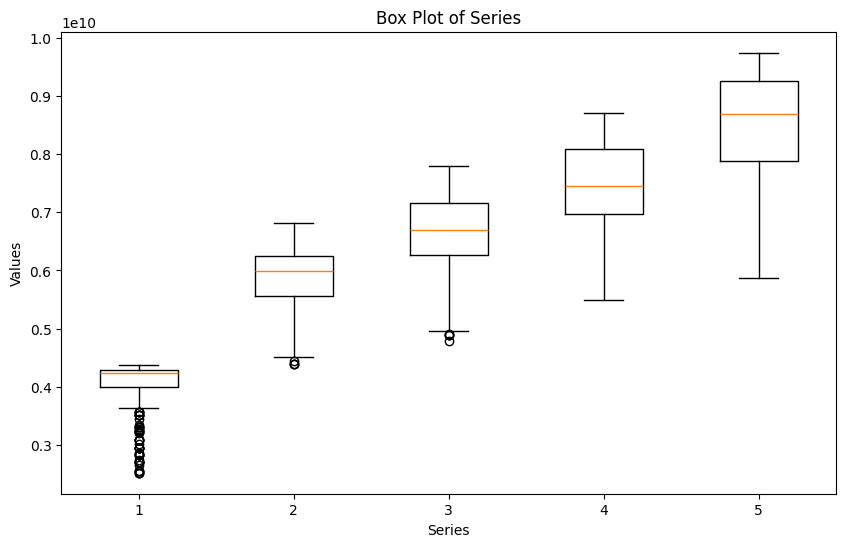

In [189]:
def plot_box_plot(data):
    """
    Plot a box plot for each array in the data list of lists.
    
    Parameters:
    data (list of lists): A list where each element is a list of float numbers.
    """
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.boxplot(data)
    
    # Adding titles and labels
    plt.title('Box Plot of Series')
    plt.xlabel('Series')
    plt.ylabel('Values')
    
    # Display the plot
    plt.show()
    
plot_box_plot(loki_inc["memSet"])

In [ ]:
plot_box_plot(loki_inc["mem"])

In [ ]:
os_inc = get_all_execs("opensearch/inc/old")
plot_box_plot(os_inc["cpu"])

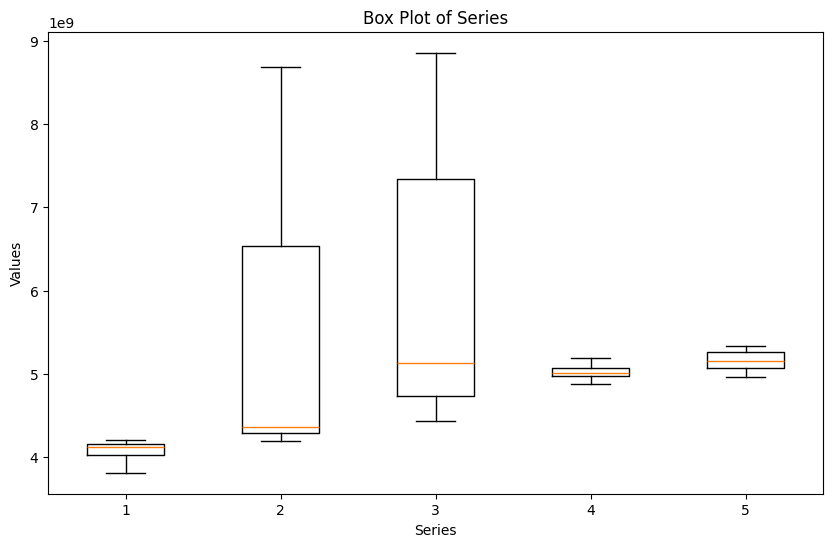

In [190]:
os_inc = get_all_execs("opensearch/inc/new")
plot_box_plot(os_inc["memSet"])

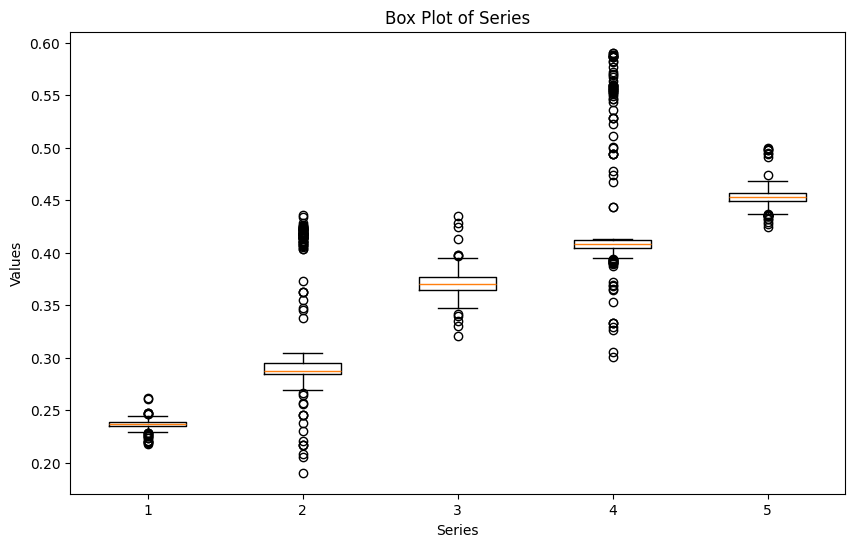

In [194]:
tempo_inc = get_all_execs("tempo/inc/actual")
plot_box_plot(tempo_inc["cpu"])

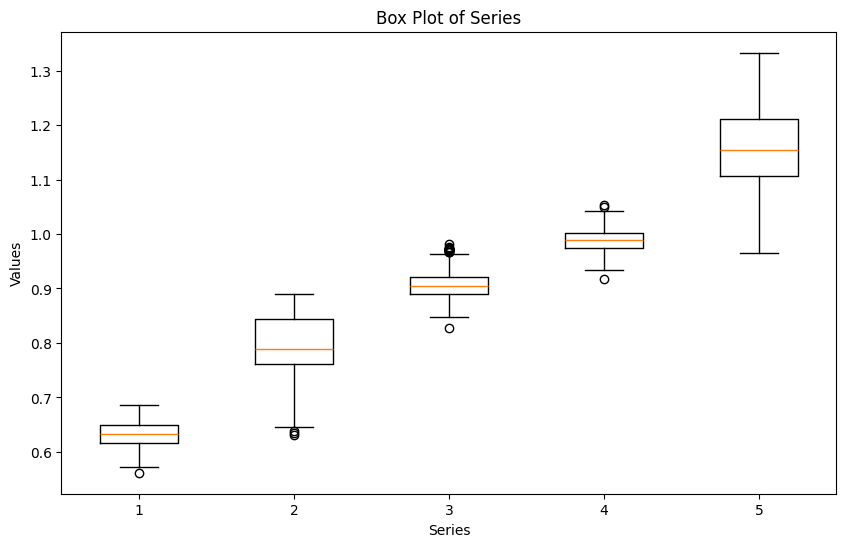

In [199]:
jaeger_inc = get_all_execs("jaeger/inc/actual")
plot_box_plot(jaeger_inc["cpu"])